# Meta Learner - LSTM + RF

## Combined Data
We Need some kind of combined data in order to predict on both types of data.

In [27]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.fft import fft

In [28]:
segments_path = '/scratch/network/jr8867/wisdm-dataset/segmented'
segments = pd.read_csv(os.path.join(segments_path, 'segments_output.csv'))
segments

,subject,activity,timestamp,ax,ay,az,gx,gy,gz,segment_id
0,1600,A,90426757,4.972757,-0.158317,6.696732,0.314944,-1.022277,-0.309962,0
1,1600,A,90426807,3.253720,-0.191835,6.107758,0.387382,-0.618541,-0.048972,0
2,1600,A,90426856,2.801216,-0.155922,5.997625,0.070999,-0.209480,-0.195978,0
3,1600,A,90426906,3.770868,-1.051354,7.731027,0.037975,0.254976,-0.156563,0
4,1600,A,90426955,4.661511,0.169689,9.684695,0.073129,0.719431,-0.001035,0
...,...,...,...,...,...,...,...,...,...,...
716420,1650,E,2425520963,8.508694,-2.731934,3.818153,0.026534,-0.016976,-0.002532,3355
716421,1650,E,2425521013,8.482357,-2.763058,3.894767,0.022273,-0.023367,-0.008924,3355
716422,1650,E,2425521063,8.508694,-2.736722,3.863643,0.029730,-0.029759,-0.006793,3355
716423,1650,E,2425521113,8.527847,-2.712780,3.887585,0.014816,-0.022302,-0.000402,3355


###  Storing Time-Series Data and Extracted features as a single data instance

In [30]:
# Define a function to extract features from each segment
def extract_features(group):
    # Calculate basic statistical features for accelerometer and gyroscope data
    features = {
        'subject': group['subject'].iloc[0],
        'activity': group['activity'].iloc[0]
    }
    
    # Mean values
    features['ax_mean'] = group['ax'].mean()
    features['ay_mean'] = group['ay'].mean()
    features['az_mean'] = group['az'].mean()
    features['gx_mean'] = group['gx'].mean()
    features['gy_mean'] = group['gy'].mean()
    features['gz_mean'] = group['gz'].mean()
    
    # Variance values
    features['ax_var'] = group['ax'].var()
    features['ay_var'] = group['ay'].var()
    features['az_var'] = group['az'].var()
    features['gx_var'] = group['gx'].var()
    features['gy_var'] = group['gy'].var()
    features['gz_var'] = group['gz'].var()
    
    # Define the sampling frequency as 20 Hz
    sampling_freq = 20  # 20 Hz sampling frequency
    # Calculate FFT features for each axis
    for axis in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
        signal = group[axis].values
        fft_result = fft(signal)
        magnitude = np.abs(fft_result)
        freq_bins = np.fft.fftfreq(len(signal), d=1/sampling_freq)  # Assuming 20 Hz sampling frequency
        
        positive_freq_idx = np.where(freq_bins > 0)[0]
        positive_magnitude = magnitude[positive_freq_idx]
        
        if len(positive_magnitude) > 0:
            features[f'{axis}_dominant_freq'] = freq_bins[positive_freq_idx][np.argmax(positive_magnitude)]
            features[f'{axis}_energy'] = np.sum(positive_magnitude**2) / len(positive_magnitude)
            normalized_magnitude = positive_magnitude / np.sum(positive_magnitude)
            entropy = -np.sum(normalized_magnitude * np.log2(normalized_magnitude + 1e-10))
            features[f'{axis}_spectral_entropy'] = entropy
            
            # Extract first few frequency components
            num_components = min(5, len(positive_magnitude))
            for i in range(num_components):
                features[f'{axis}_fft_coef_{i}'] = positive_magnitude[i]
    
    return pd.DataFrame([features])  # Return as a DataFrame

Step 1: Extract Features from the segments

In [31]:
segment_features = segments.groupby('segment_id').apply(extract_features).reset_index()
segment_features = segment_features.drop(columns=['level_1'])

In [32]:
segment_features

,segment_id,subject,activity,ax_mean,ay_mean,az_mean,gx_mean,gy_mean,gz_mean,ax_var,...,gy_fft_coef_3,gy_fft_coef_4,gz_dominant_freq,gz_energy,gz_spectral_entropy,gz_fft_coef_0,gz_fft_coef_1,gz_fft_coef_2,gz_fft_coef_3,gz_fft_coef_4
0,0,1600,A,12.122237,-1.156414,-0.070064,-0.068507,-0.063445,-0.073709,16.601585,...,12.446924,14.371058,0.990099,3224.371171,4.968058,16.391161,22.576352,15.223540,20.397892,27.502263
1,1,1600,A,12.157411,-1.728258,-1.321533,0.096809,-0.029896,0.058534,9.668744,...,8.516780,10.022383,0.995025,2442.739344,5.107389,8.912249,15.217091,16.386746,11.897987,3.097034
2,2,1600,A,12.065984,-1.527586,-0.986893,0.055010,-0.011770,-0.019493,8.831355,...,23.136238,14.551532,0.995025,2441.977851,4.933586,15.622510,18.813597,16.236460,11.243929,14.428603
3,3,1600,A,11.885556,-1.297075,-0.435071,0.131547,-0.098893,0.023381,11.100775,...,24.617817,9.747146,0.995025,2261.549563,4.982133,6.778891,2.635339,4.165685,11.845815,20.594674
4,4,1600,A,12.032942,-1.053903,0.157941,-0.034159,-0.135646,0.045277,8.280093,...,12.744734,7.523422,0.995025,2249.516356,5.037985,5.506996,9.704555,10.802612,6.539586,10.451867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351,3351,1650,E,8.653584,-4.212563,1.584637,0.001730,-0.001374,-0.000136,0.000919,...,0.224866,0.171405,0.298507,0.004190,6.033442,0.104463,0.211898,0.359368,0.108987,0.109761
3352,3352,1650,E,7.042644,-1.576809,5.595675,0.072271,-0.023187,0.055957,5.775549,...,7.460953,8.749272,0.199005,25.665597,5.227917,19.315334,26.693794,22.431478,10.970626,8.481362
3353,3353,1650,E,8.353750,-1.924051,4.661865,-0.008679,0.000174,-0.000163,0.001448,...,0.327349,0.045002,0.398010,0.009880,6.047068,0.059297,0.211567,0.218398,0.518017,0.140956
3354,3354,1650,E,7.526833,-2.096053,5.237319,-0.002743,0.024246,-0.016826,4.576234,...,25.644347,21.852596,0.398010,34.119930,5.329206,9.230250,16.610224,22.577650,24.972065,23.292780


Step 2: Store Time-Series Segment Data

In [41]:
# Iterate over segment_id groups and store each segment's data in a list
segment_groups = []
for segment_id, group in segments.groupby('segment_id'):
    # Get the activity and subject (they should be the same for all rows in a segment)
    activity = group['activity'].iloc[0]
    subject = group['subject'].iloc[0]
    
    # Keep only the sensor data columns
    group = group.sort_values(by='timestamp').reset_index(drop=True)
    sensor_data = group[['ax', 'ay', 'az', 'gx', 'gy', 'gz']].reset_index(drop=True)
    
    if len(sensor_data) == 201:  # Only append if sensor_data has 201 rows
        sensor_data_array = sensor_data.to_numpy()
        segment_groups.append((segment_id, sensor_data_array))

# Convert to DataFrame
segment_groups_df = pd.DataFrame(segment_groups, columns=['segment_id', 'segment_data'])

# Display
segment_groups_df

,segment_id,segment_data
0,1,"[[8.889671, -0.24211365, 0.15098435, 2.5742283..."
1,2,"[[12.284649, -0.65152216, 0.7639, -0.93371814,..."
2,3,"[[12.435484, -0.77362645, 0.20844519, -0.33186..."
3,4,"[[9.196129, -0.7472902, 5.4014688, -0.3808981,..."
4,5,"[[15.057135, -0.81911623, 0.6489783, -0.946553..."
...,...,...
2934,3351,"[[8.661922, -4.245069, 1.6011224, -0.004359594..."
2935,3352,"[[8.7409315, -4.149301, 1.5628152, -0.00435932..."
2936,3353,"[[8.36983, -1.7838299, 4.718373, 0.023337547, ..."
2937,3354,"[[8.365042, -2.1405659, 4.4837413, 0.026533606..."


Step 3: Join Tables

In [43]:
# Merge segment_features with segment_groups_df on segment_id
combined_df = pd.merge(segment_groups_df, segment_features, on='segment_id', how='inner')

# Display the combined DataFrame
combined_df

,segment_id,segment_data,subject,activity,ax_mean,ay_mean,az_mean,gx_mean,gy_mean,gz_mean,...,gy_fft_coef_3,gy_fft_coef_4,gz_dominant_freq,gz_energy,gz_spectral_entropy,gz_fft_coef_0,gz_fft_coef_1,gz_fft_coef_2,gz_fft_coef_3,gz_fft_coef_4
0,1,"[[8.889671, -0.24211365, 0.15098435, 2.5742283...",1600,A,12.157411,-1.728258,-1.321533,0.096809,-0.029896,0.058534,...,8.516780,10.022383,0.995025,2442.739344,5.107389,8.912249,15.217091,16.386746,11.897987,3.097034
1,2,"[[12.284649, -0.65152216, 0.7639, -0.93371814,...",1600,A,12.065984,-1.527586,-0.986893,0.055010,-0.011770,-0.019493,...,23.136238,14.551532,0.995025,2441.977851,4.933586,15.622510,18.813597,16.236460,11.243929,14.428603
2,3,"[[12.435484, -0.77362645, 0.20844519, -0.33186...",1600,A,11.885556,-1.297075,-0.435071,0.131547,-0.098893,0.023381,...,24.617817,9.747146,0.995025,2261.549563,4.982133,6.778891,2.635339,4.165685,11.845815,20.594674
3,4,"[[9.196129, -0.7472902, 5.4014688, -0.3808981,...",1600,A,12.032942,-1.053903,0.157941,-0.034159,-0.135646,0.045277,...,12.744734,7.523422,0.995025,2249.516356,5.037985,5.506996,9.704555,10.802612,6.539586,10.451867
4,5,"[[15.057135, -0.81911623, 0.6489783, -0.946553...",1600,A,11.342269,-1.470970,1.050025,0.018406,-0.144546,0.057193,...,31.608142,20.479103,0.995025,2059.064725,5.180053,1.794538,5.663979,15.011860,13.259115,20.315257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,3351,"[[8.661922, -4.245069, 1.6011224, -0.004359594...",1650,E,8.653584,-4.212563,1.584637,0.001730,-0.001374,-0.000136,...,0.224866,0.171405,0.298507,0.004190,6.033442,0.104463,0.211898,0.359368,0.108987,0.109761
2935,3352,"[[8.7409315, -4.149301, 1.5628152, -0.00435932...",1650,E,7.042644,-1.576809,5.595675,0.072271,-0.023187,0.055957,...,7.460953,8.749272,0.199005,25.665597,5.227917,19.315334,26.693794,22.431478,10.970626,8.481362
2936,3353,"[[8.36983, -1.7838299, 4.718373, 0.023337547, ...",1650,E,8.353750,-1.924051,4.661865,-0.008679,0.000174,-0.000163,...,0.327349,0.045002,0.398010,0.009880,6.047068,0.059297,0.211567,0.218398,0.518017,0.140956
2937,3354,"[[8.365042, -2.1405659, 4.4837413, 0.026533606...",1650,E,7.526833,-2.096053,5.237319,-0.002743,0.024246,-0.016826,...,25.644347,21.852596,0.398010,34.119930,5.329206,9.230250,16.610224,22.577650,24.972065,23.292780


In [44]:
# use the `pickle` module to store the DataFrame directly.
combined_df.to_pickle(os.path.join(segments_path, 'segments_master.pkl'))

In [60]:
# use the `pd.read_pickle` function.
loaded_df = pd.read_pickle(os.path.join(segments_path, 'segments_master.pkl'))

In [61]:
loaded_df.iloc[0]['segment_data']

array([[ 8.889671  , -0.24211365,  0.15098435,  2.5742283 , -1.7987487 ,
        -3.7230961 ],
       [11.36767   , -0.163105  ,  1.6138415 ,  1.4887239 , -1.1233711 ,
        -2.3989725 ],
       [11.176133  ,  0.12419921, -0.67980367, -1.7528758 , -0.24133219,
        -1.454083  ],
       ...,
       [15.55034   , -1.7552491 ,  0.39279872, -2.2290797 , -1.2266788 ,
        -2.4341323 ],
       [15.334862  , -2.5884314 ,  0.98416656, -1.5558325 , -2.757464  ,
        -4.8405647 ],
       [14.607024  , -1.3626001 ,  0.09591771, -0.6887073 , -2.1193705 ,
        -5.287976  ]])

# Model Boilerplates

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [14]:
# Create a custom dataset
class SensorDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences.astype('float32')
        self.labels = labels.astype('int64')
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return torch.tensor(sequence), torch.tensor(label)

In [51]:
# LSTM model definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        # Using nn.LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        # Initialize loss function and optimizer as instance variables
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        # x shape: (batch, seq_length, input_size)
        # out shape: (batch, seq_length, hidden_size)
        out, (hidden_n, cell_n) = self.lstm(x)
        # We'll use the output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
    def train_model(self, train_loader, num_epochs=10):
        self.train()
        progress_bar = tqdm(range(num_epochs))
        for epoch in progress_bar:
            epoch_losses = []
            for sequences, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self(sequences)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.item())
            
            avg_loss = sum(epoch_losses) / len(epoch_losses)
            progress_bar.set_description(f"Loss: {avg_loss:.4f} |")
    def get_logit(self, sequence):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            output = self(sequence)  # Get model predictions
        return output  

# Data Splits And Training

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [62]:
# Make Labels Numeric
loaded_df['activity'] = loaded_df['activity'].map({'A': 0, 'B': 1, 'D': 2, 'E': 3})

In [87]:
X_comb, X_test, y_comb, y_test = train_test_split(loaded_df, loaded_df['activity'], test_size=0.2, random_state=42)

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

# Create a global meta_df to store all fold predictions
meta_df = pd.DataFrame()

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X_comb):
    X_train, X_val = X_comb.iloc[train_index], X_comb.iloc[val_index]
    y_train, y_val = y_comb.iloc[train_index], y_comb.iloc[val_index]
    
    LSTM_X_train = []
    RF_X_train = pd.DataFrame(
        columns=[col for col in X_train.columns if col not in ['segment_id', 'segment_data', 'subject', 'activity']]
    )

    for index, row in X_train.iterrows():
        LSTM_X_train.append(row['segment_data'])
        RF_X_train.loc[index] = row.drop(['segment_id', 'segment_data', 'subject', 'activity']).values

    # Train LSTM: -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Format as np arrays
    LSTM_X_train = np.array(LSTM_X_train)
    LSTM_y_train = np.array(y_train)

    # Define model constants
    input_size = LSTM_X_train.shape[2]   # number of features
    num_classes = len(set(LSTM_y_train))  # adjust based on your unique labels

    # Create LSTM train loader
    train_dataset = SensorDataset(LSTM_X_train, LSTM_y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    lstm = LSTMModel(input_size, hidden_size=32, num_layers=2, num_classes=num_classes)
    lstm.train_model(train_loader, num_epochs=30)

    # Train RF CLF: -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=
    rf = RandomForestClassifier(
        criterion='entropy', 
        max_depth=None, 
        min_samples_split=5, 
        n_estimators=100)
    
    rf.fit(RF_X_train, y_train)


    # Get logits and store in new pandas df
    
    # Prepare validation data
    LSTM_X_val = []
    RF_X_val = pd.DataFrame(
        columns=[col for col in X_val.columns if col not in ['segment_id', 'segment_data', 'subject', 'activity']]
    )
    
    for index, row in X_val.iterrows():
        LSTM_X_val.append(row['segment_data'])
        RF_X_val.loc[index] = row.drop(['segment_id', 'segment_data', 'subject', 'activity']).values
    
    # Format LSTM validation data
    LSTM_X_val = np.array(LSTM_X_val)
    
    # Get LSTM logits
    lstm.eval()  # Set model to evaluation mode
    val_dataset = SensorDataset(LSTM_X_val, np.zeros(len(LSTM_X_val)))  # Dummy labels
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    lstm_logits = []
    with torch.no_grad():
        for inputs, _ in val_loader:
            outputs = lstm(inputs)
            lstm_logits.append(outputs.numpy())
    
    lstm_logits = np.vstack(lstm_logits)
    
    # Get RF logits (probabilities)
    rf_logits = rf.predict_proba(RF_X_val)
    
    # Create fold meta-features dataframe
    fold_meta_df = pd.DataFrame()
    fold_meta_df['segment_id'] = X_val['segment_id'].values
    
    # Add LSTM logits
    for i in range(lstm_logits.shape[1]):
        fold_meta_df[f'lstm_logit_{i}'] = lstm_logits[:, i]
    
    # Add RF logits
    for i in range(rf_logits.shape[1]):
        fold_meta_df[f'rf_logit_{i}'] = rf_logits[:, i]
    
    # Add true labels
    fold_meta_df['true_label'] = y_val.values
    
    # Append to global meta_df
    meta_df = pd.concat([meta_df, fold_meta_df], ignore_index=True)
    
    # Store results for this fold
    results.append({
        'meta_features': fold_meta_df,
        'true_labels': y_val
    })


Loss: 0.1696 |: 100%|█████████████████████████████████████████████████████| 30/30 [00:34<00:00,  1.16s/it]
Loss: 0.1526 |: 100%|█████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.31it/s]
Loss: 0.1426 |: 100%|█████████████████████████████████████████████████████| 30/30 [00:35<00:00,  1.17s/it]
Loss: 0.1095 |: 100%|█████████████████████████████████████████████████████| 30/30 [00:34<00:00,  1.16s/it]
Loss: 0.1738 |: 100%|█████████████████████████████████████████████████████| 30/30 [00:34<00:00,  1.17s/it]


In [88]:
meta_df

,segment_id,lstm_logit_0,lstm_logit_1,lstm_logit_2,lstm_logit_3,rf_logit_0,rf_logit_1,rf_logit_2,rf_logit_3,true_label
0,1236,-1.227971,5.511347,0.008116,-2.240730,0.000000,0.99,0.010000,0.000000,1
1,938,-1.794627,-3.356720,2.754633,0.294842,0.000000,0.00,0.468667,0.531333,3
2,1673,0.006979,-3.839478,-0.191422,0.968456,0.015333,0.00,0.663167,0.321500,3
3,1580,-1.204346,5.678166,0.118215,-2.442655,0.000000,1.00,0.000000,0.000000,1
4,771,-1.180595,5.733920,0.068744,-2.422917,0.000000,1.00,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...
2346,776,-0.975853,5.359042,-0.366184,-2.650870,0.000000,1.00,0.000000,0.000000,1
2347,1264,-0.929386,-4.290936,-1.856409,4.875749,0.000000,0.00,0.008571,0.991429,3
2348,2816,4.721117,-2.516101,-2.851609,-0.738267,1.000000,0.00,0.000000,0.000000,0
2349,2771,-1.093972,5.611259,-0.403175,-2.632456,0.020000,0.98,0.000000,0.000000,1


# Training Meta Learner

Meta-learner accuracy: 0.9639

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       118
           1       0.99      1.00      1.00       117
           2       0.96      0.91      0.93       118
           3       0.92      0.97      0.95       118

    accuracy                           0.96       471
   macro avg       0.96      0.96      0.96       471
weighted avg       0.96      0.96      0.96       471


Confusion Matrix:
[[115   0   2   1]
 [  0 117   0   0]
 [  1   1 107   9]
 [  1   0   2 115]]

Model Comparison:
LSTM accuracy: 0.9512
RF accuracy: 0.9724
Meta-learner accuracy: 0.9639


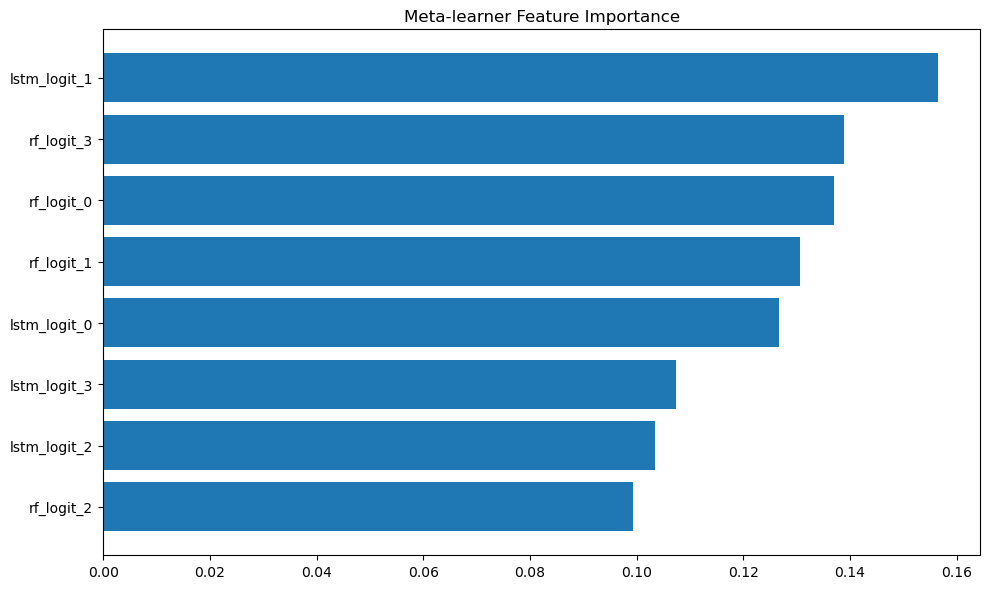

In [93]:
# Prepare data for meta-learner
X_meta = meta_df.drop(['segment_id', 'true_label'], axis=1)
y_meta = meta_df['true_label']

# Split data for meta-learner training and evaluation
from sklearn.model_selection import train_test_split
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_meta, test_size=0.2, random_state=42, stratify=y_meta
)

# Initialize and train the meta-learner
meta_learner = RandomForestClassifier(n_estimators=100, random_state=42)
meta_learner.fit(X_meta_train, y_meta_train)

# Evaluate the meta-learner
y_meta_pred = meta_learner.predict(X_meta_test)
meta_accuracy = accuracy_score(y_meta_test, y_meta_pred)

print(f"Meta-learner accuracy: {meta_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_meta_test, y_meta_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_meta_test, y_meta_pred))

# Compare with individual models
# Extract LSTM and RF features separately
lstm_features = [col for col in X_meta.columns if 'lstm' in col]
rf_features = [col for col in X_meta.columns if 'rf' in col]

# Evaluate LSTM alone
lstm_pred = X_meta_test[lstm_features].values.argmax(axis=1)
lstm_accuracy = accuracy_score(y_meta_test, lstm_pred)

# Evaluate RF alone
rf_pred = X_meta_test[rf_features].values.argmax(axis=1)
rf_accuracy = accuracy_score(y_meta_test, rf_pred)

print(f"\nModel Comparison:")
print(f"LSTM accuracy: {lstm_accuracy:.4f}")
print(f"RF accuracy: {rf_accuracy:.4f}")
print(f"Meta-learner accuracy: {meta_accuracy:.4f}")

# Feature importance
import matplotlib.pyplot as plt

feature_importance = meta_learner.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_meta.columns)[sorted_idx])
plt.title('Meta-learner Feature Importance')
plt.tight_layout()
plt.show()

In [94]:
# Save the meta-learner model to a local directory
import joblib
import os

# Create a directory to save models if it doesn't exist
models_dir = 'saved_models'
os.makedirs(models_dir, exist_ok=True)

# Save the meta-learner model
meta_learner_path = os.path.join(models_dir, 'meta_learner.joblib')
joblib.dump(meta_learner, meta_learner_path)

print(f"Meta-learner model saved to {meta_learner_path}")

Meta-learner model saved to saved_models/meta_learner.joblib


# Final Run Through

In [96]:
# Load the saved meta-learner model
models_dir = 'saved_models'
meta_learner_path = os.path.join(models_dir, 'meta_learner.joblib')
loaded_meta_learner = joblib.load(meta_learner_path)

print("Meta-learner model loaded successfully")

Meta-learner model loaded successfully


In [99]:
# Train models on the entire combined dataset (without k-fold)

# Prepare data for LSTM and RF
LSTM_X_comb = []
RF_X_comb = pd.DataFrame(
    columns=[col for col in X_comb.columns if col not in ['segment_id', 'segment_data', 'subject', 'activity']]
)

for index, row in X_comb.iterrows():
    LSTM_X_comb.append(row['segment_data'])
    RF_X_comb.loc[index] = row.drop(['segment_id', 'segment_data', 'subject', 'activity']).values

# Format as np arrays for LSTM
LSTM_X_comb = np.array(LSTM_X_comb)
LSTM_y_comb = np.array(y_comb)

# Define model constants
input_size = LSTM_X_comb.shape[2]   # number of features
num_classes = len(set(LSTM_y_comb))  # adjust based on unique labels

# Create LSTM train loader
comb_dataset = SensorDataset(LSTM_X_comb, LSTM_y_comb)
comb_loader = DataLoader(comb_dataset, batch_size=32, shuffle=True)

# Train LSTM on combined data
lstm_final = LSTMModel(input_size, hidden_size=32, num_layers=2, num_classes=num_classes)
lstm_final.train_model(comb_loader, num_epochs=100)

# Train RF on combined data
rf_final = RandomForestClassifier(
    criterion='entropy', 
    max_depth=None, 
    min_samples_split=5, 
    n_estimators=100
)
rf_final.fit(RF_X_comb, y_comb)

# Save the final models
lstm_path = os.path.join(models_dir, 'lstm_final.pt')
torch.save(lstm_final.state_dict(), lstm_path)

rf_path = os.path.join(models_dir, 'rf_final.joblib')
joblib.dump(rf_final, rf_path)

print(f"Final LSTM model saved to {lstm_path}")
print(f"Final RF model saved to {rf_path}")

Loss: 0.0558 |: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


Final LSTM model saved to saved_models/lstm_final.pt
Final RF model saved to saved_models/rf_final.joblib


Loaded LSTM model from saved_models/lstm_final.pt
Loaded RF model from saved_models/rf_final.joblib
Loaded Meta-learner model from saved_models/meta_learner.joblib

Test Set Performance:
LSTM accuracy: 0.9405
RF accuracy: 0.9456
Meta-learner accuracy: 0.9524


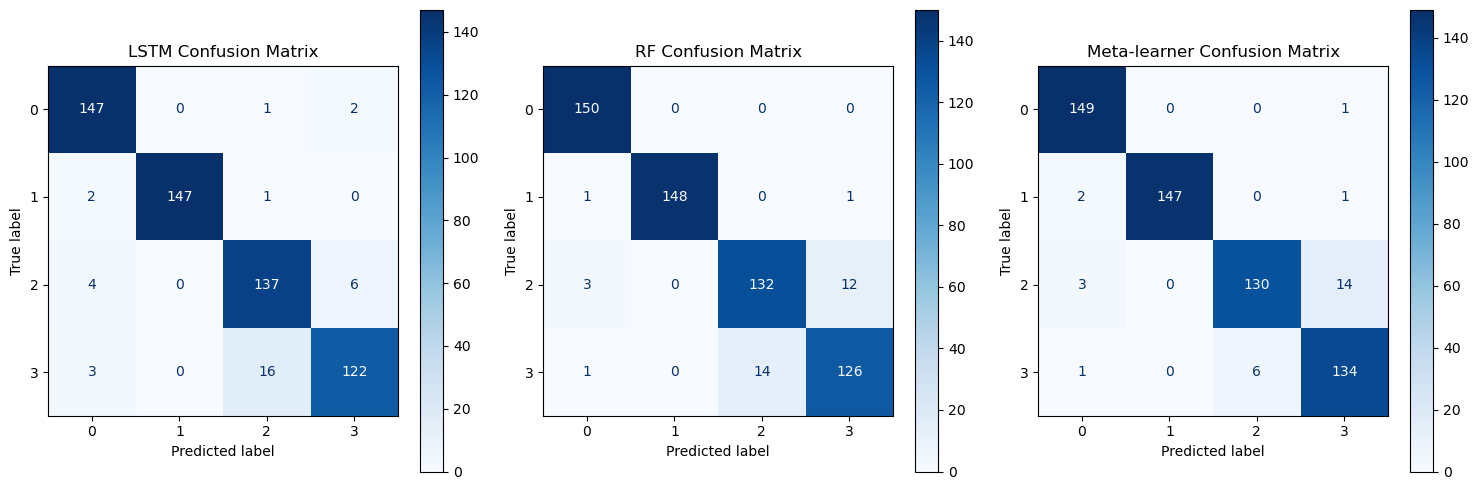

,Model,Class,Accuracy,F1 Score,Precision,Recall
0,LSTM,0,0.980000,0.960784,0.942308,0.980000
1,LSTM,1,0.980000,0.989899,1.000000,0.980000
2,LSTM,2,0.931973,0.907285,0.883871,0.931973
3,LSTM,3,0.865248,0.900369,0.938462,0.865248
4,LSTM,Overall,0.940476,0.940349,0.941494,0.940476
5,RF,0,1.000000,0.983607,0.967742,1.000000
6,RF,1,0.986667,0.993289,1.000000,0.986667
7,RF,2,0.897959,0.901024,0.904110,0.897959
8,RF,3,0.893617,0.900000,0.906475,0.893617
9,RF,Overall,0.945578,0.945382,0.945371,0.945578


In [100]:
# Load LSTM model
loaded_lstm = LSTMModel(input_size, hidden_size=32, num_layers=2, num_classes=num_classes)
loaded_lstm.load_state_dict(torch.load(lstm_path))
loaded_lstm.eval()  # Set to evaluation mode

# Load Random Forest model
loaded_rf = joblib.load(rf_path)

# Load Meta-learner model
meta_path = os.path.join(models_dir, 'meta_learner.joblib')
loaded_meta = joblib.load(meta_path)

print(f"Loaded LSTM model from {lstm_path}")
print(f"Loaded RF model from {rf_path}")
print(f"Loaded Meta-learner model from {meta_path}")

# Prepare test data
LSTM_X_test = []
RF_X_test = pd.DataFrame(
    columns=[col for col in X_test.columns if col not in ['segment_id', 'segment_data', 'subject', 'activity']]
)

for index, row in X_test.iterrows():
    LSTM_X_test.append(row['segment_data'])
    RF_X_test.loc[index] = row.drop(['segment_id', 'segment_data', 'subject', 'activity']).values

# Format LSTM test data
LSTM_X_test = np.array(LSTM_X_test)

# Get LSTM logits for test data
lstm_final.eval()  # Set model to evaluation mode
test_dataset = SensorDataset(LSTM_X_test, np.zeros(len(LSTM_X_test)))  # Dummy labels
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

lstm_test_logits = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = lstm_final(inputs)
        lstm_test_logits.append(outputs.numpy())

lstm_test_logits = np.vstack(lstm_test_logits)

# Get RF logits (probabilities) for test data
rf_test_logits = rf_final.predict_proba(RF_X_test)

# Create test meta-features dataframe
test_meta_df = pd.DataFrame()
test_meta_df['segment_id'] = X_test['segment_id'].values

# Add LSTM logits
for i in range(lstm_test_logits.shape[1]):
    test_meta_df[f'lstm_logit_{i}'] = lstm_test_logits[:, i]

# Add RF logits
for i in range(rf_test_logits.shape[1]):
    test_meta_df[f'rf_logit_{i}'] = rf_test_logits[:, i]

# Add true labels
test_meta_df['true_label'] = y_test.values

# Make predictions using the meta-learner
X_test_meta = test_meta_df.drop(['segment_id', 'true_label'], axis=1)
y_test_meta = test_meta_df['true_label']

meta_predictions = loaded_meta.predict(X_test_meta)
meta_accuracy = accuracy_score(y_test_meta, meta_predictions)

# Individual model predictions
lstm_predictions = np.argmax(lstm_test_logits, axis=1)
lstm_accuracy = accuracy_score(y_test_meta, lstm_predictions)

rf_predictions = rf_final.predict(RF_X_test)
rf_accuracy = accuracy_score(y_test_meta, rf_predictions)

print(f"\nTest Set Performance:")
print(f"LSTM accuracy: {lstm_accuracy:.4f}")
print(f"RF accuracy: {rf_accuracy:.4f}")
print(f"Meta-learner accuracy: {meta_accuracy:.4f}")

# Create confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm_lstm = confusion_matrix(y_test_meta, lstm_predictions)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm)
disp_lstm.plot(ax=plt.gca(), cmap='Blues')
plt.title('LSTM Confusion Matrix')

plt.subplot(1, 3, 2)
cm_rf = confusion_matrix(y_test_meta, rf_predictions)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(ax=plt.gca(), cmap='Blues')
plt.title('RF Confusion Matrix')

plt.subplot(1, 3, 3)
cm_meta = confusion_matrix(y_test_meta, meta_predictions)
disp_meta = ConfusionMatrixDisplay(confusion_matrix=cm_meta)
disp_meta.plot(ax=plt.gca(), cmap='Blues')
plt.title('Meta-learner Confusion Matrix')

plt.tight_layout()
plt.show()

# Calculate per-class metrics for each model
models = ['LSTM', 'RF', 'Meta-learner']
all_preds = [lstm_predictions, rf_predictions, meta_predictions]
all_metrics = []

for model_name, preds in zip(models, all_preds):
    # Calculate per-class accuracy
    cm = confusion_matrix(y_test_meta, preds)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # Calculate precision and recall
    precision = precision_score(y_test_meta, preds, average=None)
    recall = recall_score(y_test_meta, preds, average=None)
    
    # Calculate F1 scores
    f1_scores = f1_score(y_test_meta, preds, average=None)
    
    # Create metrics for each class
    for class_idx in range(len(class_accuracy)):
        all_metrics.append({
            'Model': model_name,
            'Class': class_idx,
            'Accuracy': class_accuracy[class_idx],
            'F1 Score': f1_scores[class_idx],
            'Precision': precision[class_idx],
            'Recall': recall[class_idx]
        })
    
    # Add overall metrics
    all_metrics.append({
        'Model': model_name,
        'Class': 'Overall',
        'Accuracy': accuracy_score(y_test_meta, preds),
        'F1 Score': f1_score(y_test_meta, preds, average='weighted'),
        'Precision': precision_score(y_test_meta, preds, average='weighted'),
        'Recall': recall_score(y_test_meta, preds, average='weighted')
    })

# Create a comprehensive DataFrame with all metrics
metrics_df = pd.DataFrame(all_metrics)
metrics_df